In [224]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# убираем предупреждения о прекращении поддержки.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

PATH = './sf-scoring'
train = pd.read_csv(f'{PATH}/train.csv', delimiter=',')
test = pd.read_csv(f'{PATH}/test.csv', delimiter=',')

data = pd.concat([train, test], ignore_index=True)

|Поле | Описание |
| :-               | :-                                    |
|client_id | идентификатор клиента|
|education | уровень образования|
|sex | пол заемщика|
|age | возраст заемщика|
|car | флаг наличия автомобиля|
|car_type | флаг автомобиля иномарки|
|decline_app_cnt | количество отказанных прошлых заявок|
|good_work | флаг наличия “хорошей” работы|
|bki_request_cnt | количество запросов в БКИ|
|home_address | категоризатор домашнего адреса|
|work_address | категоризатор рабочего адреса|
|income | доход заемщика|
|foreign_passport | наличие загранпаспорта|
|sna | связь заемщика с клиентами банка|
|first_time | давность наличия информации о заемщике|
|score_bki | скоринговый балл по данным из БКИ|
|region_rating | рейтинг региона|
|app_date | дата подачи заявки|
|default | флаг дефолта по кредиту|

In [225]:
# сводим информацию по доступным признакам
data.agg({'nunique', lambda s: s.unique()[:5]} )\
    .append(pd.Series(data.dropna().min(), name='min'))\
    .append(pd.Series(data.dropna().max(), name='max'))\
    .append(pd.Series(data.isnull().sum(), name='null'))\
    .append(pd.Series(data.dtypes, name='dtype'))\
    .transpose()

,<lambda_0>,nunique,min,max,null,dtype
client_id,"[25905, 63161, 25887, 16222, 101655]",110148,1,110147,0,int64
app_date,"[01FEB2014, 12MAR2014, 23JAN2014, 18APR2014, 1...",120,01APR2014,31MAR2014,0,object
education,"[SCH, GRD, UGR, PGR, ACD]",5,ACD,UGR,478,object
sex,"[M, F]",2,F,M,0,object
age,"[62, 59, 25, 53, 48]",52,21,72,0,int64
car,"[Y, N]",2,N,Y,0,object
car_type,"[Y, N]",2,N,Y,0,object
decline_app_cnt,"[0, 2, 1, 3, 4]",24,0,33,0,int64
good_work,"[0, 1]",2,0,1,0,int64
score_bki,"[-2.00875292, -1.53227621, -1.40814226, -2.057...",102618,-3.62459,0.199773,0,float64


In [226]:
# группируем признаки по типам
num_cols = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
cat_cols = ['education', 'home_address', 'work_address', 'sna', 'first_time', 'region_rating']

Есть пропуски в признаке 'education'. Пропуски будем заполнятьсамым распространенным значением - 'SCH'.
Сразу приведем значения категориальных признаков к int.

In [227]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# приводим значения бинарных признаков к int
for column in bin_cols:
        train[column] = label_encoder.fit_transform(train[column])
        test[column] = label_encoder.fit_transform(test[column])

# составляем словарь для маппинга education
education_index = {
    'SCH': 0,
    'UGR': 1,
    'GRD': 2,
    'PGR': 3,
    'ACD': 4,
}

# приводим значения признака к int
train.education = train.education.apply(lambda x: education_index.get(x, 0))
test.education = test.education.apply(lambda x: education_index.get(x, 0))

Внимательнее посмотрим на распределение нашей целевой переменной.

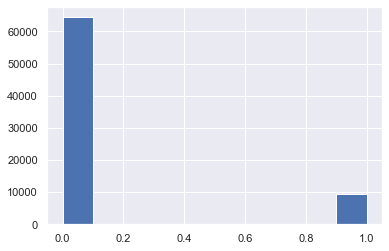

In [228]:
train.default.hist();

Целевая переменная не сбалансирована. Есть смысл увеличить вес класса "1" (был дефолт) при обучении модели,
поскольку перед нам стоит задача предсказания вероятности дефолта.

Теперь рассмотрим числовые признаки.

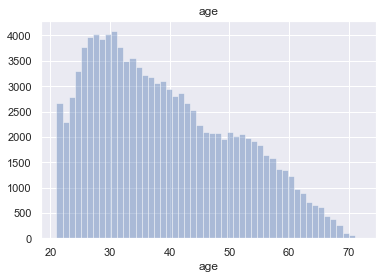

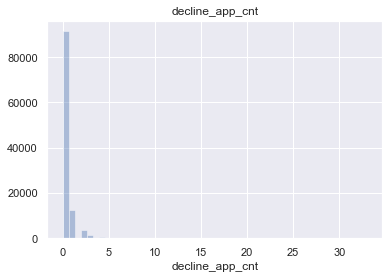

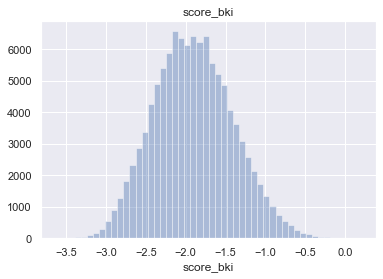

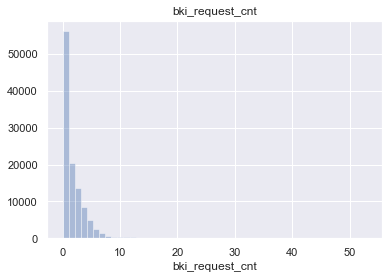

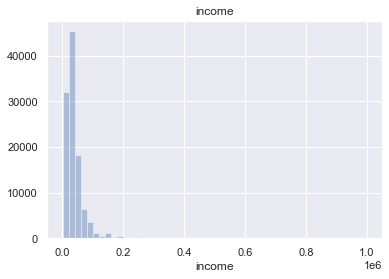

In [229]:
for col in num_cols:
    plt.figure()
    sns.distplot(data[col], kde=False, rug=False)
    plt.title(col)
    plt.show()

Сильный перепад значений в признаке 'income', логарифмируем.

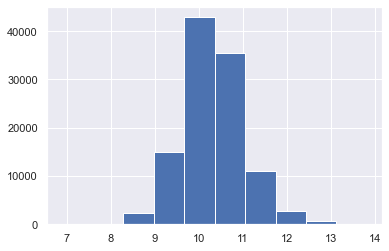

In [230]:
train.income = train.income.apply(lambda x: np.log(x+1))
test.income = test.income.apply(lambda x: np.log(x+1))

data.income.apply(lambda x: np.log(x+1)).hist();

Посмотрим на корреляцию между числовыми признаками и целевой переменной.

<AxesSubplot:>

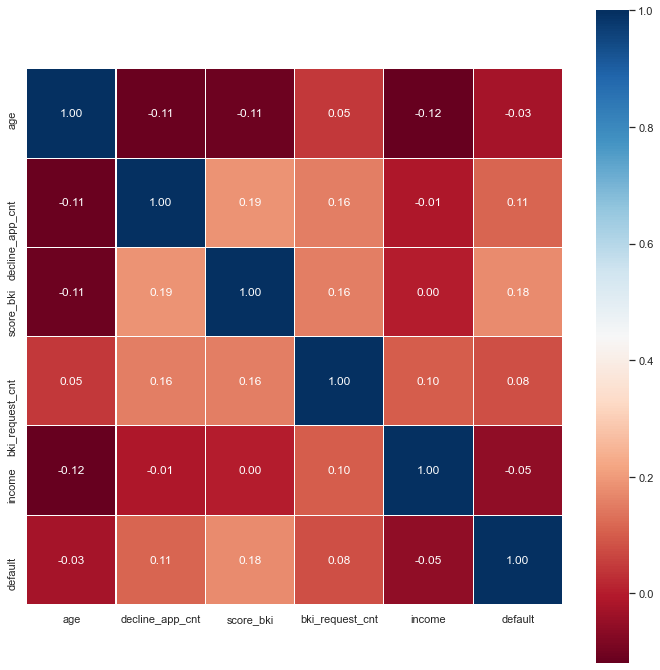

In [231]:
sns.set(font_scale=1)
plt.subplots(figsize=(12, 12))
sns.heatmap(train[num_cols + ['default']].corr(), square=True,
              annot=True, fmt=".2f", linewidths=0.1, cmap="RdBu")

Признаки скоррелированы слабо.

Посмотрим на значимость числовых и категориальных признаков.

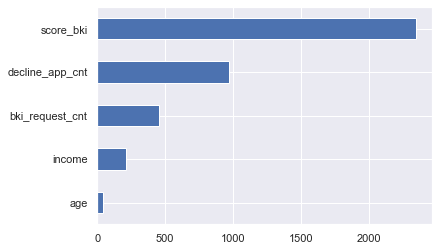

In [232]:
from sklearn.feature_selection import f_classif

# значимость числовых признаков
imp_num = pd.Series(f_classif(train[num_cols], train['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh');

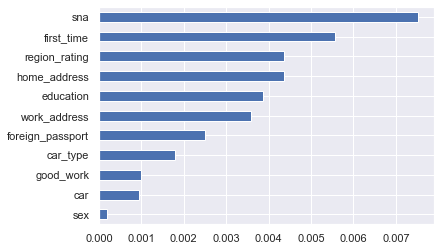

In [233]:
from sklearn.feature_selection import mutual_info_classif

# значимость категориальных признаков
imp_cat = pd.Series(mutual_info_classif(train[bin_cols + cat_cols], train['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh');

Наибольшую значимость имееют:
1. рейтинг БКИ
1. связь с другими клиентами
1. давность информации.

Для предсказания вероятности дефолта мы будем использовать логистическую регрессию.
Подготовим данные и обучим нашу модель. При выборе параметров модели учитываем дисбаланс классов.

In [234]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# определяем и сохраняем параметры стандартизации
scaler = StandardScaler()
scaler.fit(train[num_cols])

def prepare(df, scaler):

    # стандартизируем числовые признаки
    X_num = scaler.transform(df[num_cols].values)

    # создаем dummy признаки из категориальных
    X_cat = OneHotEncoder(sparse = False).fit_transform(df[cat_cols].values)

    return np.hstack([X_num, df[bin_cols].values, X_cat])

In [235]:
from sklearn.model_selection import train_test_split

# подготавливаем и разделяем данные
X, Y = prepare(train, scaler), train['default']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.3)


In [236]:
from sklearn.linear_model import LogisticRegression

# обучаем модель, используем балансировку классов.
model = LogisticRegression(class_weight='balanced').fit(X_train, y_train)

Пострим ROC_AUC и матрицу ошибок для нашей модели, чтобы оценить качество её работы.

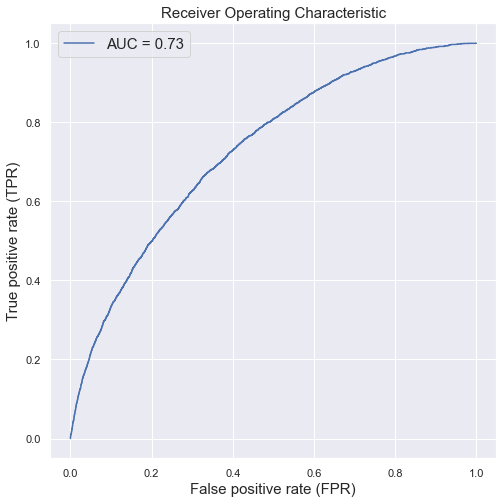

In [237]:
from sklearn.metrics import roc_auc_score, roc_curve

def calc_and_plot_roc(y_test, y_pred_proba):
    # Посчитать значения ROC кривой и значение площади под кривой AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.title('Receiver Operating Characteristic', fontsize=15)
    plt.xlabel('False positive rate (FPR)', fontsize=15)
    plt.ylabel('True positive rate (TPR)', fontsize=15)
    plt.legend(fontsize=15)

calc_and_plot_roc(y_test, model.predict_proba(X_test)[:, 1])

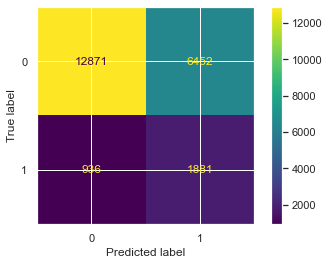

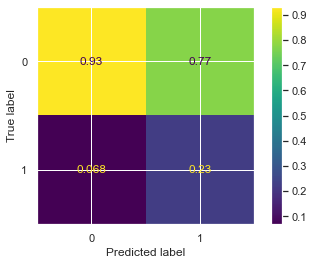

In [238]:
from sklearn.metrics import plot_confusion_matrix

def confusion_matrix(X_test, y_test):
    plot_confusion_matrix(model, X_test, y_test)
    plot_confusion_matrix(model, X_test, y_test, normalize='pred')
    plt.show();

confusion_matrix(X_test, y_test)

Результат выглядит приемлемым.
Число ложноположительных прогнозов (есть дефолт) составляет около 7%.

Попробуем улучшить результаты за счет подбора гиперпараметров.

In [239]:
from sklearn.model_selection import GridSearchCV

model_search = LogisticRegression(random_state=42)

iter_ = 50
epsilon_stop = 1e-3

param_grid = [
    {'penalty': ['l1'],
     'solver': ['liblinear', 'lbfgs'],
     'class_weight':['none', 'balanced'],
     'multi_class': ['auto','ovr'],
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'],
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
     'class_weight':['none', 'balanced'],
     'multi_class': ['auto','ovr'],
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'],
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
     'class_weight':['none', 'balanced'],
     'multi_class': ['auto','ovr'],
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]

## model ваша модель логистической регрессии
gridsearch = GridSearchCV(model_search, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model_search = gridsearch.best_estimator_

##печатаем параметры
best_parameters = model_search.get_params()
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))


	C: 1.0
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 100
	multi_class: 'auto'
	n_jobs: None
	penalty: 'l1'
	random_state: 42
	solver: 'liblinear'
	tol: 0.001
	verbose: 0
	warm_start: False


In [240]:
# обучим модель заново с новыми гиперпараметрами
model = LogisticRegression(**best_parameters).fit(X_train, y_train)


Оценим изменения в качестве работы модели.

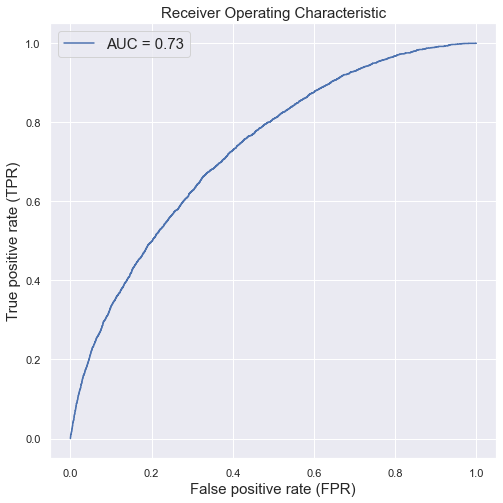

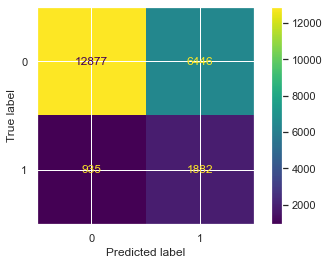

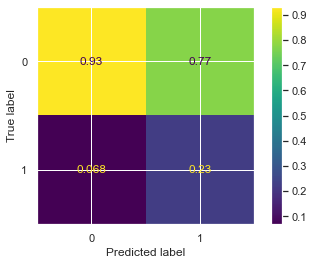

In [241]:
calc_and_plot_roc(y_test, model.predict_proba(X_test)[:, 1])
confusion_matrix(X_test, y_test)

Изменения незначительны, в дальнейшем можно попробовать добиться улучшения за за счет feature engineering.
Публикуем результаты.

In [243]:
y_valid_proba = model.predict(prepare(test, scaler))
result = test[['client_id']].copy()
result['default'] = y_valid_proba

result.to_csv(f'submission.csv', index=False)